In [1]:
!pip install transformers torch


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
import pandas as pd

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
train_df = pd.read_csv('/teamspace/studios/this_studio/archive (6)/twitter_training.csv')  
val_df = pd.read_csv('/teamspace/studios/this_studio/archive (6)/twitter_validation.csv')  


In [5]:
X_train = train_df.iloc[:, 3].fillna('').astype(str).tolist()  # 4ª coluna: Texto dos tweets
y_train = train_df.iloc[:, 2].values  # 3ª coluna: Sentimento


In [6]:
X_val = val_df.iloc[:, 3].fillna('').astype(str).tolist()  # 4ª coluna: Texto dos tweets
y_val = val_df.iloc[:, 2].values  # 3ª coluna: Sentimento


In [7]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [9]:
def tokenize_data(texts, tokenizer, max_len=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')


In [10]:
train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)

In [11]:
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)


In [12]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)


In [13]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [14]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  # Número de classes
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 4
num_training_steps = epochs * len(train_loader)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [18]:
def calculate_metrics(preds, labels):
    preds = torch.argmax(preds, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    accuracy = (preds == labels).mean()
    
    return accuracy, f1, precision, recall

In [19]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, epochs=3, patience=3):
    early_stopping_counter = 0
    best_val_loss = float('inf')
    
    # Armazenar as métricas
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "train_f1": [],
        "val_f1": [],
        "train_precision": [],
        "val_precision": [],
        "train_recall": [],
        "val_recall": []
    }

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Treinamento
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        
        for batch in tqdm(train_loader):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            all_train_preds.append(outputs.logits.detach())
            all_train_labels.append(labels.detach())
        
        train_loss /= len(train_loader)
        all_train_preds = torch.cat(all_train_preds)
        all_train_labels = torch.cat(all_train_labels)
        
        train_acc, train_f1, train_precision, train_recall = calculate_metrics(all_train_preds, all_train_labels)
        
        # Armazenar métricas de treinamento
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["train_precision"].append(train_precision)
        history["train_recall"].append(train_recall)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Train F1: {train_f1:.4f} | Train Precision: {train_precision:.4f} | "
              f"Train Recall: {train_recall:.4f}")
        
        # Validação
        model.eval()
        val_loss = 0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader):
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                
                val_loss += outputs.loss.item()
                all_val_preds.append(outputs.logits)
                all_val_labels.append(labels)
        
        val_loss /= len(val_loader)
        all_val_preds = torch.cat(all_val_preds)
        all_val_labels = torch.cat(all_val_labels)
        
        val_acc, val_f1, val_precision, val_recall = calculate_metrics(all_val_preds, all_val_labels)

        # Armazenar métricas de validação
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        history["val_precision"].append(val_precision)
        history["val_recall"].append(val_recall)
        
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Val F1: {val_f1:.4f} | Val Precision: {val_precision:.4f} | "
              f"Val Recall: {val_recall:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Plotando as métricas
    plot_metrics(history)
    
    # Matriz de Confusão
    plot_confusion_matrix(all_val_labels.cpu().numpy(), torch.argmax(all_val_preds, dim=1).cpu().numpy())


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

In [21]:
def plot_metrics(history):
    epochs_range = range(len(history["train_loss"]))
    
    plt.figure(figsize=(12, 8))
    
    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    plt.plot(epochs_range, history["val_loss"], label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Loss")

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs_range, history["val_acc"], label="Validation Accuracy")
    plt.legend(loc="upper right")
    plt.title("Accuracy")

    # Plot Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, history["train_precision"], label="Train Precision")
    plt.plot(epochs_range, history["val_precision"], label="Validation Precision")
    plt.legend(loc="upper right")
    plt.title("Precision")

    # Plot Recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, history["train_recall"], label="Train Recall")
    plt.plot(epochs_range, history["val_recall"], label="Validation Recall")
    plt.legend(loc="upper right")
    plt.title("Recall")

    plt.tight_layout()
    plt.show()

In [22]:
patience = 2

Epoch 1/4


100%|██████████| 4668/4668 [03:48<00:00, 20.44it/s]


Train Loss: 0.6890 | Train Acc: 0.7357 | Train F1: 0.7335 | Train Precision: 0.7345 | Train Recall: 0.7357


100%|██████████| 63/63 [00:00<00:00, 65.65it/s]


Val Loss: 0.1678 | Val Acc: 0.9560 | Val F1: 0.9560 | Val Precision: 0.9575 | Val Recall: 0.9560
Epoch 2/4


100%|██████████| 4668/4668 [03:49<00:00, 20.31it/s]


Train Loss: 0.2071 | Train Acc: 0.9235 | Train F1: 0.9235 | Train Precision: 0.9237 | Train Recall: 0.9235


100%|██████████| 63/63 [00:00<00:00, 66.20it/s]


Val Loss: 0.1046 | Val Acc: 0.9690 | Val F1: 0.9690 | Val Precision: 0.9694 | Val Recall: 0.9690
Epoch 3/4


100%|██████████| 4668/4668 [03:49<00:00, 20.38it/s]


Train Loss: 0.1022 | Train Acc: 0.9579 | Train F1: 0.9580 | Train Precision: 0.9582 | Train Recall: 0.9579


100%|██████████| 63/63 [00:00<00:00, 65.03it/s]


Val Loss: 0.1108 | Val Acc: 0.9730 | Val F1: 0.9730 | Val Precision: 0.9733 | Val Recall: 0.9730
Epoch 4/4


100%|██████████| 4668/4668 [03:50<00:00, 20.28it/s]


Train Loss: 0.0689 | Train Acc: 0.9685 | Train F1: 0.9686 | Train Precision: 0.9688 | Train Recall: 0.9685


100%|██████████| 63/63 [00:00<00:00, 65.41it/s]


Val Loss: 0.1097 | Val Acc: 0.9790 | Val F1: 0.9790 | Val Precision: 0.9791 | Val Recall: 0.9790
Early stopping at epoch 4


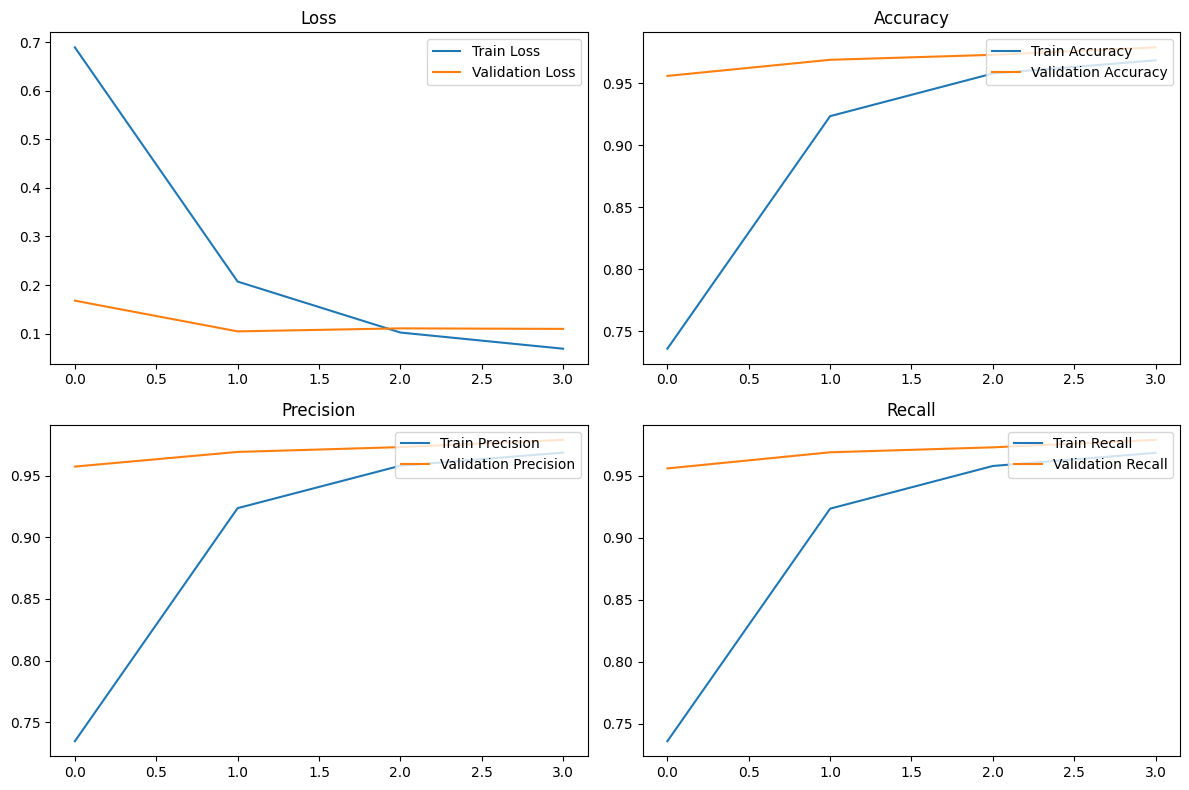

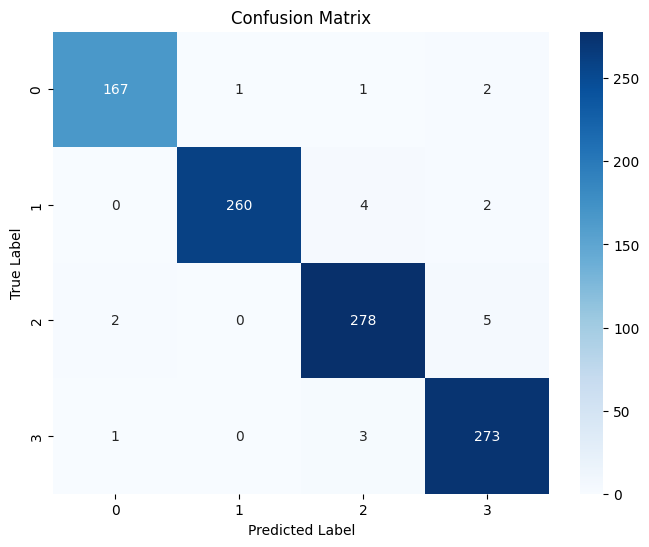

In [23]:
train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, epochs, patience)
